In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from tqdm import tqdm
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import scipy.stats as stats
import statsmodels.stats.multicomp as mc
from scipy.stats import normaltest
from scipy.stats import shapiro
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
import math
import os

# CMA aging Atlas: Liver from 10x.
Data downloaded from [Tabula muris senis](https://cellxgene.cziscience.com/collections/0b9d8a04-bb9d-44da-aa27-705bb65b54eb) project. Liver data, 10X 3'v2 assay in .h5ad format was used for further analysis. Decision made to cover absence of Kuppfer cells female young in the Smart-seq2 database.

In [2]:
# Creating folder for outputs
os.makedirs('../Khwaja_et_al_outputs/Liver10X')

## Importing and preprocessing data

In [2]:
# Import h5ad file in scanpy. 
adata = sc.read_h5ad('../Exp. 2_Tabula muris/Files/TM_liver_10x.h5ad')

# Normalize as CPM (counts per million)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e6)

# Transforming CPM into log form
sc.pp.log1p(adata)

## CMA score calculation

In [4]:
# Load matrix file with weight and direction 
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx')

# No need to remove EEF1A1 and RAC1 genes, in 10X approach they appeared

# Finding CMA network genes in the dataset
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# Calculating the Zs scores
cma_data_zs = cma_network.copy().X.todense().T

for i in tqdm(np.arange(cma_data_zs.shape[0])):
    
    µ = np.mean(cma_data_zs[i, :])
    sd = np.std(cma_data_zs[i, :])
    
    cma_data_zs[i, :] = (cma_data_zs[i, :] - µ)/sd
    
# Generating a copy of adata.obs to work with
barcode = adata.obs.copy()

# New column in barcode (aka adata.obs) with the CMA scores for each cell detected
for i,j in enumerate(barcode.index):
        
    cell_matrix = model_matrix.copy()

    for g in cell_matrix.index:

        cell_matrix.loc[g, 'gene_count'] = cma_data_zs[g, i]

    cell_matrix['gene_score'] = cell_matrix['gene_count'] * cell_matrix['Direction'] * cell_matrix['Weight']
    score = cell_matrix['gene_score'].sum()/np.sum(cell_matrix['Weight'])

    barcode.loc[j, 'score'] = score   
    

100%|████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 1499.22it/s]


In [5]:
barcode.head()

,age,cell,free_annotation,method,mouse.id,n_genes,subtissue,n_counts,louvain,leiden,...,organism_ontology_term_id,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,NCBITaxon:10090,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.802074
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,NCBITaxon:10090,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,0.022096
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,NCBITaxon:10090,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.367613
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568848,1,1,...,NCBITaxon:10090,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.307165
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,NCBITaxon:10090,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.265594


## CMA net score/cell type (fold over whole tissue)

In [6]:
# Checking n of mice 
list(barcode['mouse.id'].unique())

['18-F-51',
 '21-F-54',
 '24-M-58',
 '24-M-59',
 '30-M-3',
 '30-M-4',
 '30-M-5',
 '1-M-62',
 '1-M-63',
 '3-M-8/9',
 '3-F-56',
 '3-F-57']

**Mice n for Liver**
    - Young females: 2
    - Young males: 3
    - Old females: 2
    - Old males: 5

In [7]:
# Generating new ages
for j in barcode.index:    
    if barcode.loc[j, 'age'] == '1m':        
        barcode.loc[j, 'new_age'] = '1-3m'
    
    elif barcode.loc[j, 'age'] == '3m':                
        barcode.loc[j, 'new_age'] = '1-3m'

    elif barcode.loc[j, 'age'] == '18m':                
        barcode.loc[j, 'new_age'] = '18-30m'

    elif barcode.loc[j, 'age'] == '21m': 
        barcode.loc[j, 'new_age'] = '18-30m'
    
    elif barcode.loc[j, 'age'] == '24m':                
        barcode.loc[j, 'new_age'] = '18-30m'

    elif barcode.loc[j, 'age'] == '30m':                
        barcode.loc[j, 'new_age'] = '18-30m'

barcode.head()

,age,cell,free_annotation,method,mouse.id,n_genes,subtissue,n_counts,louvain,leiden,...,cell_type,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.802074,18-30m
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,0.022096,18-30m
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.367613,18-30m
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568848,1,1,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.307165,18-30m
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,hepatocyte,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.265594,18-30m


In [8]:
# Calculation of net score to 3m using whole tissue CMA score mean
µ = np.mean(barcode[barcode['new_age'] == '1-3m']['score'])

for i in barcode.index:
    barcode.loc[i, 'net_score'] = barcode.loc[i, 'score'] - µ 

barcode.head()

,age,cell,free_annotation,method,mouse.id,n_genes,subtissue,n_counts,louvain,leiden,...,assay,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,net_score
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.802074,18-30m,-0.784991
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,0.022096,18-30m,0.039179
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.367613,18-30m,-0.350530
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568848,1,1,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.307165,18-30m,-0.290082
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,10x 3' v2,normal,Mus musculus,female,liver,na,18 month-old stage,-0.265594,18-30m,-0.248512


In [9]:
print(list(barcode.cell_type.unique()))

['hepatocyte', 'endothelial cell of hepatic sinusoid', 'Kupffer cell', 'hepatic stellate cell', 'natural killer cell', 'plasmacytoid dendritic cell', 'B cell', 'myeloid leukocyte', 'duct epithelial cell']


In [3]:
cells = ['hepatocyte', 'Kupffer cell'] 

### Cell types stats

In [11]:
# Function for testing normality using D'Agostino-Pearson of different cell types and ages
def normalidad (df, tipo, años):
    long = []
    cell = []
    age = []
    estadistica=[]
    pval=[]
    result=[]   
    
    for x in tipo:
        for y in años:
            mydata = df[(df['cell_type']== x) & (df['new_age']== y)]
            n = len(mydata.index)
            data = list(mydata.net_score)            
            stat, p = normaltest(data)
            long.append(n)
            cell.append(x)
            age.append(y)
            estadistica.append(stat)
            pval.append(p)
            if p > 0.05:
                result.append("Normal")
            else:
                result.append("Not normal")    
    df_norm = pd.DataFrame({"Cell": cell, "Age": age, "n": long, "Stat":estadistica, "p value": pval, "Result":result})
    return(df_norm)

In [12]:
normalidad(barcode, tipo=cells, años=['1-3m', '18-30m'])

,Cell,Age,n,Stat,p value,Result
0,hepatocyte,1-3m,2304,159.401698,2.434227e-35,Not normal
1,hepatocyte,18-30m,625,193.390407,1.013460e-42,Not normal
2,Kupffer cell,1-3m,627,13.715740,1.051150e-03,Not normal
3,Kupffer cell,18-30m,1919,391.330745,1.055865e-85,Not normal


In [13]:
# Calculating MWU test for not normally distributed cell populations
for i in cells:
    group3 = list(barcode[barcode.cell_type==i][barcode.new_age=='1-3m']['net_score'])
    group18_24 = list(barcode[barcode.cell_type==i][barcode.new_age=='18-30m']['net_score'])
    print('{} statistics'.format(i.title()))
    stat, p = stats.mannwhitneyu(group3, group18_24)
    print("MWU test pval = " + str(p))
    print('\n')

Hepatocyte statistics
MWU test pval = 3.318065721962236e-12


Kupffer Cell statistics
MWU test pval = 1.056979706286134e-59




C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\2381568594.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group3 = list(barcode[barcode.cell_type==i][barcode.new_age=='1-3m']['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\2381568594.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  group18_24 = list(barcode[barcode.cell_type==i][barcode.new_age=='18-30m']['net_score'])


### Net score graph

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\208386632.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y1= np.mean(barcode[barcode.cell_type =='hepatocyte'][barcode.new_age=='18-30m']['net_score']) - (0.013)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\208386632.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y2= np.mean(barcode[barcode.cell_type =='Kupffer cell'][barcode.new_age=='18-30m']['net_score']) - (0.013)


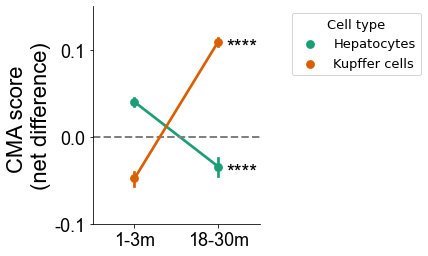

In [18]:
# CMA net score by cell type
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.pointplot(x='new_age', y='net_score', data=barcode, hue='cell_type', order=["1-3m", "18-30m"], 
              hue_order=["hepatocyte", 'Kupffer cell'], palette="Dark2", ci=68)
plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticklabels(["1-3m", "18-30m"], fontdict={'family':'Arial', 'size': 18})
plt.xlabel('')
plt.ylim(-0.10, 0.15) 
ax.set_yticks([-0.10, 0.00, 0.10])
ax.set_yticklabels([-0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})

# Legend
celulas = ["Hepatocytes", 'Kupffer cells']
h, l = ax.get_legend_handles_labels()
ax.legend(h, celulas, bbox_to_anchor=(2, 1), title="Cell type", title_fontsize = "13", fontsize=13) 

# Stats
x1= 1.1   
y1= np.mean(barcode[barcode.cell_type =='hepatocyte'][barcode.new_age=='18-30m']['net_score']) - (0.013)
y2= np.mean(barcode[barcode.cell_type =='Kupffer cell'][barcode.new_age=='18-30m']['net_score']) - (0.013)
plt.text(x1, y1, "****", fontsize=20, **hfont)
plt.text(x1, y2, "****", fontsize=20, **hfont)

plt.savefig('../Khwaja_et_al_outputs/Liver10X/Liv10x_nscorrect.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [65]:
# Extracting raw values for pointplot graphic
long = []
celula = []
age = []
mean=[]
sem=[]

for x in cells:
    for y in ['1-3m', '18-30m']:
        n = len(barcode[barcode['cell_type']== x][barcode['new_age']== y].index)
        m = np.mean(barcode[barcode['cell_type']== x][barcode['new_age']== y]['net_score'])
        s = stats.sem(np.array(barcode[barcode['cell_type']== x][barcode['new_age']== y]['net_score']))
        
        long.append(n)
        celula.append(x)
        age.append(y)
        mean.append(m)
        sem.append(s)
        
df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "n": long, "Mean":mean, "SEM": sem})
df_raw

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\2602072609.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['cell_type']== x][barcode['new_age']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\2602072609.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['cell_type']== x][barcode['new_age']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\2602072609.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(np.array(barcode[barcode['cell_type']== x][barcode['new_age']== y]['net_score']))


,Cell_type,Age,n,Mean,SEM
0,hepatocyte,1-3m,2304,0.040110,0.004556
1,hepatocyte,18-30m,625,-0.034189,0.009854
2,Kupffer cell,1-3m,627,-0.047850,0.008163
3,Kupffer cell,18-30m,1919,0.109354,0.004655


In [66]:
df_raw.to_excel('../Khwaja_et_al_outputs/Liver10X/Raw_data.xlsx', 'Netsc', index=False)

## CMA net score/cell type & sex  (fold over whole tissue)

### Stats

In [22]:
# Calculating n of cells per cell type, sex and age
for i in cells:
    print(i.title() + " length:" + str(len(barcode[barcode["cell_type"]==i].index)))
    print(barcode[barcode["cell_type"]==i].value_counts(["sex", "new_age"]))
    print("\n")

Hepatocyte length:2929
sex     new_age
male    1-3m       1768
female  1-3m        536
        18-30m      517
male    18-30m      108
dtype: int64


Kupffer Cell length:2546
sex     new_age
male    18-30m     1673
        1-3m        614
female  18-30m      246
        1-3m         13
dtype: int64




In [23]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode[barcode['cell_type']==i].reset_index()    
    
    # 2-way Anova
    model = ols('net_score ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['net_score'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Hepatocyte 2-way Anova

                       df      sum_sq   mean_sq          F        PR(>F)
C(new_age)            1.0    2.714019  2.714019  53.741504  2.944839e-13
C(sex)                1.0    0.145290  0.145290   2.876947  8.996264e-02
C(new_age):C(sex)     1.0    0.150159  0.150159   2.973372  8.475089e-02
Residual           2925.0  147.716449  0.050501        NaN           NaN


Hepatocyte Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1          group2      stat   pval  pval_corr reject
--------------------------------------------------------------
  1-3m & female     1-3m & male 0.8312 0.4059       1.0  False
  1-3m & female 18-30m & female 5.0136    0.0       0.0   True
  1-3m & female   18-30m & male 5.1271    0.0       0.0   True
    1-3m & male 18-30m & female 5.6536    0.0       0.0   True
    1-3m & male   18-30m & male 5.3595    0.0       0.0   True
18-30m & female   18-30m & male 2.0849 0.03

### Graphs

#### Hepatocytes

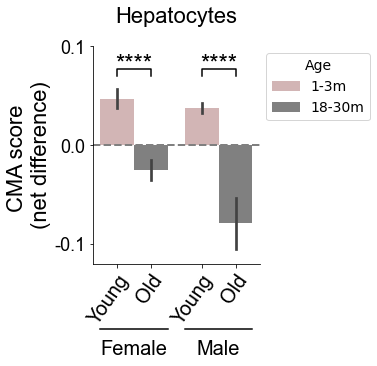

In [29]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.cell_type=='hepatocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['1-3m', "18-30m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.12, 0.10)
ax.set_yticks([-0.10, 0.00, 0.10])
ax.set_yticklabels([-0.10, 0.00, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['1-3m', "18-30m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Hepatocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.07 , 0.007, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -0.2, .2   
y, h, col = 0.07 , 0.007, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Liver10X/Hepat10x_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Kupffer cells

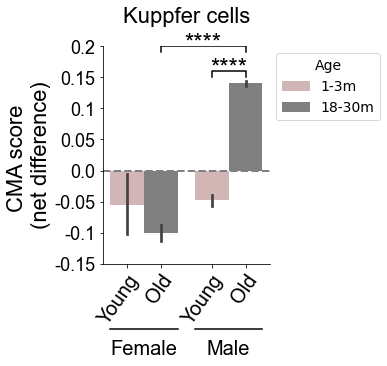

In [43]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='net_score', data=barcode[barcode.cell_type=='Kupffer cell'], 
            hue='new_age', order=["female", "male"], hue_order=['1-3m', "18-30m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.15, 0.20)
ax.set_yticks([-0.15, -0.10, -0.05, 0.0, 0.05, 0.10, 0.15, 0.20])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.0, 0.05, 0.10, 0.15, 0.20], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['1-3m', "18-30m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Kuppfer cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)
 
# statistical annotation
x1, x2 = 0.8, 1.2   
y1, h, col = 0.15, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y1, y1+h, y1+h, y1], lw=1.5, c=col)
plt.text((x1+x2)*.5, y1-0.005, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y2, h, col = 0.19, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y2, y2+h, y2+h, y2], lw=1.5, c=col)
plt.text((x1+x2)*.5, y2-0.005, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Liver10X/Kupf10x_ns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [67]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
                s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Liver10X/Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="Nsbysex", index=False)
    return(df_raw)

In [68]:
raw(tipos = cells, edad=['1-3m', '18-30m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\3308927593.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\3308927593.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\3308927593.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['net_score'])


,Cell_type,Age,Sex,n,Mean,SEM
0,hepatocyte,1-3m,female,536,0.046989,0.009703
1,hepatocyte,1-3m,male,1768,0.038025,0.005158
2,hepatocyte,18-30m,female,517,-0.024824,0.010560
3,hepatocyte,18-30m,male,108,-0.079020,0.026078
4,Kupffer cell,1-3m,female,13,-0.054775,0.049874
5,Kupffer cell,1-3m,male,614,-0.047703,0.008274
6,Kupffer cell,18-30m,female,246,-0.099825,0.012770
7,Kupffer cell,18-30m,male,1673,0.140112,0.004537


## CMA net score/cell type & sex (fold over each cell type young)

In [47]:
# Calculation of net score (fold to 3m for each individual cell type)
for maj_cell in tqdm(np.unique(barcode['cell_type'])):
    
    µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '1-3m']['score'])
    
    for cell_index in barcode[barcode['cell_type'] == maj_cell].index:
    
        barcode.loc[cell_index, 'celltype_ns'] = barcode.loc[cell_index, 'score'] - µ  

barcode.head()

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\2912173661.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  µ = np.mean(barcode[barcode['cell_type'] == maj_cell][barcode['new_age'] == '1-3m']['score'])
100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  7.70it/s]


,age,cell,free_annotation,method,mouse.id,n_genes,subtissue,n_counts,louvain,leiden,...,disease,organism,sex,tissue,ethnicity,development_stage,score,new_age,net_score,celltype_ns
index,,,,,,,,,,,,,,,,,,,,,
AAACCTGAGATGTCGG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,nan,droplet,18-F-51,1116.0,Hepatocytes,3650.349121,0,5,...,normal,Mus musculus,female,liver,na,18 month-old stage,-0.802074,18-30m,-0.784991,-0.825101
AAAGCAATCGGAAATA-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1976.0,Hepatocytes,4931.057617,1,1,...,normal,Mus musculus,female,liver,na,18 month-old stage,0.022096,18-30m,0.039179,-0.000932
AAAGTAGAGGCCCTTG-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1897.0,Hepatocytes,5164.586426,1,1,...,normal,Mus musculus,female,liver,na,18 month-old stage,-0.367613,18-30m,-0.350530,-0.390640
AACCGCGAGAAACCGC-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1501.0,Hepatocytes,4340.568848,1,1,...,normal,Mus musculus,female,liver,na,18 month-old stage,-0.307165,18-30m,-0.290082,-0.330192
AACTCCCAGTTGTCGT-1-9-0-0,18m,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,"Hepatocyte (Pericentral, Midlobular, Periportal)",droplet,18-F-51,1710.0,Hepatocytes,4656.192871,1,1,...,normal,Mus musculus,female,liver,na,18 month-old stage,-0.265594,18-30m,-0.248512,-0.288622


### Graphs

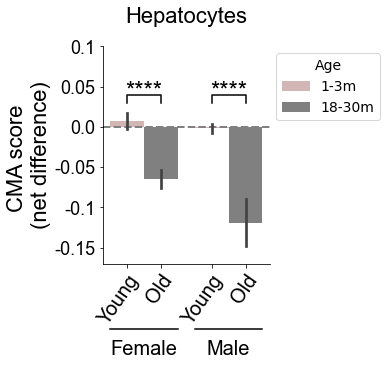

In [50]:
# Figure Hepatocytes
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type=='hepatocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['1-3m', "18-30m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.17, 0.10)
ax.set_yticks([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10])
ax.set_yticklabels([-0.15, -0.10, -0.05, 0.00, 0.05, 0.10], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['1-3m', "18-30m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Hepatocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = -0.2, .2   
y, h, col = 0.03 , 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Liver10X/Hepat10x_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

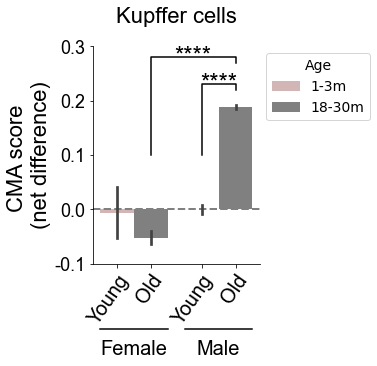

In [51]:
# Figure Kupffer cells
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='celltype_ns', data=barcode[barcode.cell_type=='Kupffer cell'], 
            hue='new_age', order=["female", "male"], hue_order=['1-3m', "18-30m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('CMA score \n(net difference)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.10, 0.30)
ax.set_yticks([-0.10, 0.00, 0.10, 0.20, 0.30])
ax.set_yticklabels([-0.10, 0.00, 0.10, 0.20, 0.30], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['1-3m', "18-30m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14)
plt.title(label='Kupffer cells', fontdict={'family':'Arial', 'size': 22}, y=1.08)

# statistical annotation
x1, x2 = 0.8, 1.2   
y1, y2, h, col = 0.1, 0.22, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y1, y2+h, y2+h, y2], lw=1.5, c=col)
plt.text((x1+x2)*.5, y2-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y1, y2, h, col = 0.1, 0.27, 0.01, 'k'
plt.plot([x1, x1, x2, x2], [y1, y2+h, y2+h, y2], lw=1.5, c=col)
plt.text((x1+x2)*.5, y2-h, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Liver10X/Kupf10x_cellns_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [69]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
                m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
                s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Liver10X/Raw_data.xlsx", mode="a", engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="CellNsbysex", index=False)
    return(df_raw)

In [70]:
raw(tipos = cells, edad=['1-3m', '18-30m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\2729345835.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\2729345835.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\2729345835.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode[barcode['cell_type']== i][barcode['new_age']== x][barcode['sex']== y]['celltype_ns'])


,Cell_type,Age,Sex,n,Mean,SEM
0,hepatocyte,1-3m,female,536,0.006879,0.009703
1,hepatocyte,1-3m,male,1768,-0.002085,0.005158
2,hepatocyte,18-30m,female,517,-0.064934,0.010560
3,hepatocyte,18-30m,male,108,-0.119130,0.026078
4,Kupffer cell,1-3m,female,13,-0.006925,0.049874
5,Kupffer cell,1-3m,male,614,0.000147,0.008274
6,Kupffer cell,18-30m,female,246,-0.051975,0.012770
7,Kupffer cell,18-30m,male,1673,0.187962,0.004537


## CMA network heatmaps by cell type & sex

In [54]:
# Load matrix reordered
model_matrix = pd.read_excel('../Exp. 2_Tabula muris/activation_model.xlsx', 'reordered')

# Mapping data from adata to new order of CMA network
cma_network = adata[:, model_matrix["Ensembl_ms"]]

# GFAP does not appear in some cell types, creating a list without it
nogfap = ['LAMP2', 'HSPA8', 'HSP90AA1', 'HSP90AB1', 'DNAJB1', 'EEF1A1', 'PHLPP1', 'RAC1', 'NFATC1', 'NCOR1', 'NFE2L2', 
          'RAB11A', 'RICTOR', 'AKT1', 'AKT2', 'CTSA', 'RARA']

In [71]:
def sex_heatmaps(cellpop):
    
    # Prepare empty matrix
    matrix = np.zeros((18, 4))
    
    #Find cell indices for each condition
    female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "1-3m"].index)
    female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-30m"].index)
    male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "1-3m"].index)
    male_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "18-30m"].index)
    
    #Calculate mean per gene for every condition
    for rank in tqdm(np.arange(matrix.shape[0])):    
        matrix[rank, 0] = np.mean(cma_network[female_3m, :].X.todense()[:, rank])
        matrix[rank, 1] = np.mean(cma_network[female_18_24m, :].X.todense()[:, rank])
        matrix[rank, 2] = np.mean(cma_network[male_3m, :].X.todense()[:, rank])
        matrix[rank, 3] = np.mean(cma_network[male_18_24m, :].X.todense()[:, rank])
            
    #Perform z-scoring on each row
    matrix_zs = matrix.copy()

    for i in np.arange(matrix_zs.shape[0]):
    
        µ = np.mean(matrix_zs[i, :])
        sd = np.std(matrix_zs[i, :])
    
        matrix_zs[i, :] = (matrix_zs[i, :] - µ) / sd     
    
    # Saving raw data
    df_m = pd.DataFrame(matrix_zs, columns=['female_young', 'female_old', 'male_young', 'male_old'], 
                        index=model_matrix['Gene name'])
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Liver10X/Raw_data.xlsx", mode="a", if_sheet_exists='replace',
                        engine="openpyxl", ) as writer:
        df_m.to_excel(writer, sheet_name=cellpop[:4]+'_heat', index=True)
        
    # Plotting with all proteins
    if cellpop == cells[1]:
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(18), model_matrix['Gene name'], fontsize=16, **hfont)

        plt.ylim(17.5, -0.5)

        plt.xticks(np.arange(4), ['1-3m', '18-30m', '1-3m', '18-30m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        plt.title(label='Kupffer cells', fontdict={'family':'Arial', 'size': 22}, y=1.05)
        
        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.6, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.35,-1.35],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.6, 5.5), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.35,-1.35],[4.75, 12.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.6, 12), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.35,-1.35],[12.75, 17.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.05, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.7, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.6, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)
        
    else: # plotting without GFAP
        matrix_zs = np.delete(matrix_zs,(5), axis=0)
        fig, ax = plt.subplots(figsize=(6,6))
        hfont = {'fontname':'Arial'}
        plt.imshow(matrix_zs, cmap='viridis', vmin=-1.5, vmax=1.5) 
        plt.colorbar(shrink=.5).set_label(label="Gene Z score", size=16, **hfont)

        plt.yticks(np.arange(17), nogfap, fontsize=16, **hfont)

        plt.ylim(16.5, -0.5)

        plt.xticks(np.arange(4), ['1-3m', '18-30m', '1-3m', '18-30m'], rotation=55, ha='right', rotation_mode='anchor',fontsize=16, **hfont)
        plt.axvline(x=1.5, linestyle='dashed', linewidth=2, color='k', zorder=1)
        plt.title(label='Hepatocytes', fontdict={'family':'Arial', 'size': 22}, y=1.05)

        # Annotations
        trans = ax.get_yaxis_transform()
        trans2 = ax.get_xaxis_transform()
        ax.annotate('Effectors', xy=(-1.6, 0), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='k', size=16, **hfont)
        ax.plot([-1.35,-1.35],[-0.25, 4.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Pos. regulators', xy=(-1.6, 5.1), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='green', size=16, **hfont)
        ax.plot([-1.35,-1.35],[4.75, 11.15], color="k", transform=trans, clip_on=False)
        ax.annotate('Neg. regulators', xy=(-1.6, 11.3), xycoords=trans, ha='left', rotation=90, va="top", 
                    color='red', size=16, **hfont)
        ax.plot([-1.35,-1.35],[11.75, 16.25], color="k", transform=trans, clip_on=False)
        ax.annotate('Female', xy=(0.05, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([-.5,1.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

        ax.annotate('Male', xy=(2.7, -.22), xycoords=trans2, ha="center", va="top", size=16, **hfont)
        ax.plot([1.6, 3.25],[-.2,-.2], color="k", transform=trans2, clip_on=False)

    
    plt.savefig('../Khwaja_et_al_outputs/Liver10X/{}_heat.png'.format(cellpop[:4]),bbox_inches='tight', dpi=300)
    
    plt.show()

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\1856220374.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "1-3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\1856220374.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-30m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\1856220374.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "1-3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\1856220374.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_typ

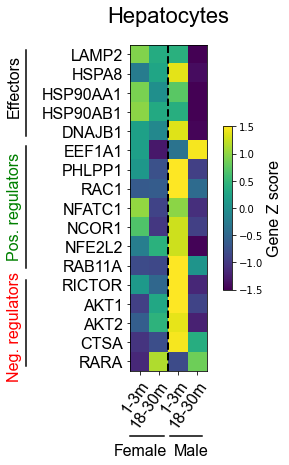

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\1856220374.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "1-3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\1856220374.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  female_18_24m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "female"][barcode['new_age'] == "18-30m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\1856220374.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_3m = list(barcode[barcode['cell_type'] == cellpop][barcode['sex'] == "male"][barcode['new_age'] == "1-3m"].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\1856220374.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  male_18_24m = list(barcode[barcode['cell_typ

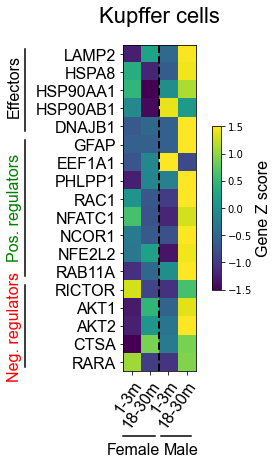

In [72]:
for i in cells:
    sex_heatmaps(cellpop=i)

## Ridge plots for L2 and L1

In [4]:
# Codes for L2 and L1
lys = ['ENSMUSG00000016534', 'ENSMUSG00000031447']

In [5]:
# Selecting only L2 and L1 from adata
adata_lys = adata[:, lys]
barcode_lys = adata.obs.copy()

# Calculating the Z score for L2 & L1
lys_zs = adata_lys.copy().X.todense()

for i in tqdm(np.arange(lys_zs.shape[1])):
    
    µ = np.mean(lys_zs[:, i])
    sd = np.std(lys_zs[:, i])
    
    lys_zs[:, i] = (lys_zs[:, i] - µ)/sd
    
# Converting lys_zs.X to a pandas df
df_lys = pd.DataFrame(lys_zs.tolist())
df_lys.rename(columns={0:"L2", 1:'L1'}, inplace=True)

# Generating barcode df and appending L2 column
barcode_lys = barcode_lys.reset_index()
barcode_lys = pd.concat([barcode_lys, df_lys], axis=1)
barcode_lys = barcode_lys [['index', 'cell', 'cell_type', 'sex', 'age', 'L2', 'L1']]

barcode_lys.head()

100%|████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<?, ?it/s]


,index,cell,cell_type,sex,age,L2,L1
0,AAACCTGAGATGTCGG-1-9-0-0,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,hepatocyte,female,18m,-2.119043,0.518726
1,AAAGCAATCGGAAATA-1-9-0-0,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,hepatocyte,female,18m,0.637017,0.298255
2,AAAGTAGAGGCCCTTG-1-9-0-0,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,hepatocyte,female,18m,0.544065,-0.008066
3,AACCGCGAGAAACCGC-1-9-0-0,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,hepatocyte,female,18m,0.669813,0.454110
4,AACTCCCAGTTGTCGT-1-9-0-0,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,hepatocyte,female,18m,0.614330,0.287516


In [6]:
# Generating new ages
for j in barcode_lys.index:    
    if barcode_lys.loc[j, 'age'] == '1m':        
        barcode_lys.loc[j, 'new_age'] = '1-3m'
    
    elif barcode_lys.loc[j, 'age'] == '3m':                
        barcode_lys.loc[j, 'new_age'] = '1-3m'

    elif barcode_lys.loc[j, 'age'] == '18m':                
        barcode_lys.loc[j, 'new_age'] = '18-30m'

    elif barcode_lys.loc[j, 'age'] == '21m': 
        barcode_lys.loc[j, 'new_age'] = '18-30m'
    
    elif barcode_lys.loc[j, 'age'] == '24m':                
        barcode_lys.loc[j, 'new_age'] = '18-30m'

    elif barcode_lys.loc[j, 'age'] == '30m':                
        barcode_lys.loc[j, 'new_age'] = '18-30m'
        
barcode_lys.head()

,index,cell,cell_type,sex,age,L2,L1,new_age
0,AAACCTGAGATGTCGG-1-9-0-0,MACA_18m_F_LIVER_HEPATOCYTES_51_AAACCTGAGATGTCGG,hepatocyte,female,18m,-2.119043,0.518726,18-30m
1,AAAGCAATCGGAAATA-1-9-0-0,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGCAATCGGAAATA,hepatocyte,female,18m,0.637017,0.298255,18-30m
2,AAAGTAGAGGCCCTTG-1-9-0-0,MACA_18m_F_LIVER_HEPATOCYTES_51_AAAGTAGAGGCCCTTG,hepatocyte,female,18m,0.544065,-0.008066,18-30m
3,AACCGCGAGAAACCGC-1-9-0-0,MACA_18m_F_LIVER_HEPATOCYTES_51_AACCGCGAGAAACCGC,hepatocyte,female,18m,0.669813,0.454110,18-30m
4,AACTCCCAGTTGTCGT-1-9-0-0,MACA_18m_F_LIVER_HEPATOCYTES_51_AACTCCCAGTTGTCGT,hepatocyte,female,18m,0.614330,0.287516,18-30m


In [7]:
# Reducing df only to cells of interest
barcode_lys = barcode_lys[(barcode_lys.cell_type==cells[0]) | (barcode_lys.cell_type==cells[1])].reset_index(drop=True)

### Graphs

#### Lamp2 female

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


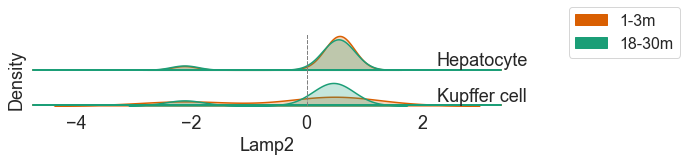

In [8]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['1-3m', '18-30m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=1.65, s="Hepatocyte", fontsize=18) 
plt.text(x=2.25, y=0.15, s="Kupffer cell", fontsize=18) 

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='1-3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-30m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Liver10X/Liv10xL2_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp2 male

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


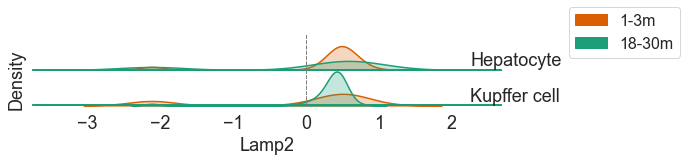

In [9]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['1-3m', '18-30m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L2', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=2.80, s="Hepatocyte", fontsize=18) 
plt.text(x=2.25, y=0.25, s="Kupffer cell", fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp2')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='1-3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-30m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.4, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Liver10X/Liv10xL2_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 female

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


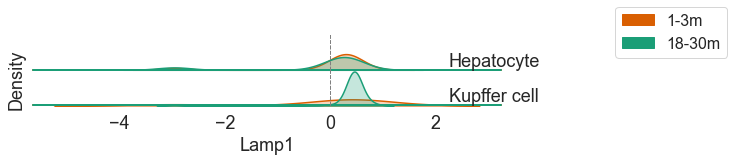

In [10]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'female'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['1-3m', '18-30m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=2.8, s="Hepatocyte", fontsize=18) 
plt.text(x=2.25, y=0.30, s="Kupffer cell", fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='1-3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-30m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.5, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Liver10X/Liv10xL1_ridge_fem.png',bbox_inches='tight', dpi=300)
plt.show()

#### Lamp1 male

C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Adrian\anaconda3\envs\scrna\lib\site-packages\seaborn\axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


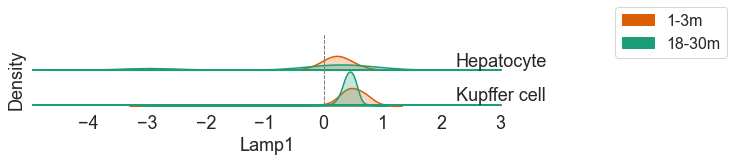

In [11]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), "axes.labelsize":18, "xtick.labelsize":18}, 
              font_scale=2)

g = sns.FacetGrid(barcode_lys[barcode_lys.sex == 'male'], row='cell_type', row_order = cells, hue='new_age', 
                  hue_order= ['1-3m', '18-30m'], aspect=7, height=1.1, palette=['#d95f02', '#1b9e77'])
g.map(sns.kdeplot, 'L1', bw_adjust=1, clip_on=False, fill=True, alpha=0.25, linewidth=1.5)
g.map(plt.axhline, y=0, lw=2, clip_on=False)
g.map(plt.axvline, x=0, lw=1, clip_on=False, color='gray', linestyle='dashed')

g.fig.subplots_adjust(hspace=0)

plt.text(x=2.25, y=3.85, s="Hepatocyte", fontsize=18) 
plt.text(x=2.25, y=0.45, s="Kupffer cell", fontsize=18)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel='')
g.set(xlabel='Lamp1')
g.fig.text(0.04, 0.5, 'Density', va='center', rotation='vertical', fontsize=18)
g.despine(bottom=True, left=True)

# Legend
legend_elements = [Patch(facecolor='#d95f02', edgecolor='#d95f02', label='1-3m'),
                   Patch(facecolor='#1b9e77', edgecolor='#1b9e77', label='18-30m')]

plt.legend(handles=legend_elements, bbox_to_anchor = (1.5, 3), facecolor='white', fontsize=16)

plt.savefig('../Khwaja_et_al_outputs/Liver10X/Liv10xL1_ridge_male.png',bbox_inches='tight', dpi=300)
plt.show()

## L2 Bar graphs

### Stats

In [101]:
# 2-way Anova for all cells
for i in cells:
    intdf = barcode_lys[barcode_lys['cell_type']==i].reset_index(drop=True)    
    
    # 2-way Anova
    model = ols('L2 ~ C(new_age) + C(sex) + C(new_age):C(sex)',data=intdf).fit()
    result = sm.stats.anova_lm(model, type=2)
    print(i.title()+' 2-way Anova\n')
    print(result)
    print('\n')
    
    # Post hocs multi comparissons Bonferroni
    interaction_groups = intdf.new_age.astype(str) + " & " + intdf.sex.astype(str)
    comp = mc.MultiComparison(intdf['L2'], interaction_groups)
    tbl, a1, a2 = comp.allpairtest(stats.ttest_ind, method= "bonf")
    print(i.title()+' Post-Hoc Bonferroni\n')
    print(tbl)
    print('\n')

Hepatocyte 2-way Anova

                       df       sum_sq   mean_sq         F    PR(>F)
C(new_age)            1.0     2.637176  2.637176  4.243216  0.039496
C(sex)                1.0     5.841715  5.841715  9.399321  0.002190
C(new_age):C(sex)     1.0     3.066607  3.066607  4.934172  0.026407
Residual           2925.0  1817.899053  0.621504       NaN       NaN


Hepatocyte Post-Hoc Bonferroni

Test Multiple Comparison ttest_ind 
FWER=0.05 method=bonf
alphacSidak=0.01, alphacBonf=0.008
     group1          group2      stat   pval  pval_corr reject
--------------------------------------------------------------
  1-3m & female     1-3m & male 1.9205 0.0549    0.3295  False
  1-3m & female 18-30m & female 1.6331 0.1027    0.6164  False
  1-3m & female   18-30m & male 4.0498 0.0001    0.0003   True
    1-3m & male 18-30m & female   0.23 0.8181       1.0  False
    1-3m & male   18-30m & male 3.6741 0.0002    0.0015   True
18-30m & female   18-30m & male 2.9002 0.0039    0.0232   True


### Graphs

In [102]:
sns.reset_defaults()

#### Hepatocytes

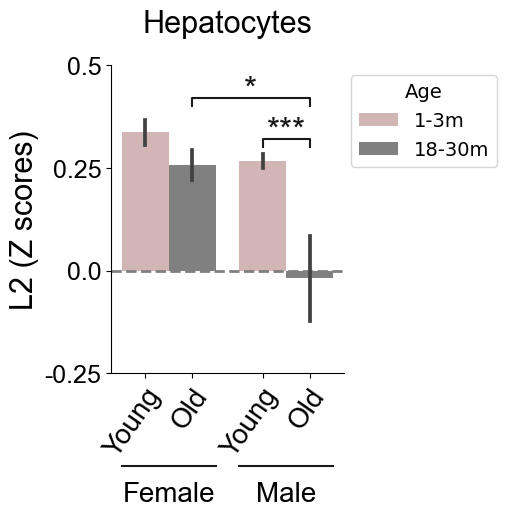

In [112]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.cell_type=='hepatocyte'], 
            hue='new_age', order=["female", "male"], hue_order=['1-3m', "18-30m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.25, 0.5)
ax.set_yticks([-0.25, 0.0, 0.25, 0.50])
ax.set_yticklabels([-0.25,0.0, 0.25, 0.50], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['1-3m', "18-30m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Hepatocytes', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.30 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "***", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.40 , 0.02, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y, "*", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})
 
# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Liver10X/Hepat10x_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

#### Kuppfer cells

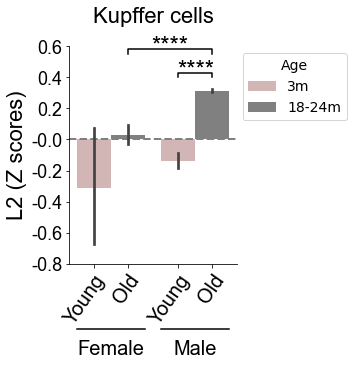

In [8]:
fig, ax = plt.subplots(figsize=(3,4))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
hfont = {'fontname':'Arial'}

sns.barplot(x='sex', y='L2', data=barcode_lys[barcode_lys.cell_type=='Kupffer cell'], 
            hue='new_age', order=["female", "male"], hue_order=['1-3m', "18-30m"], palette=['#D7B0B0', '#808080'], ci=68)

plt.axhline(y=0, linestyle='dashed', linewidth=2, color='gray', zorder=1)
plt.xlabel('')
plt.ylabel('L2 (Z scores)', fontdict={'family':'Arial', 'size': 22})
ax.set_xticks([-0.2, 0.2, 0.8, 1.2])
ax.set_xticklabels(["Young", "Old", "Young", "Old"], fontdict={'family':'Arial', 'size': 20}, 
                   rotation=55, ha='right', rotation_mode='anchor')
plt.ylim(-0.8, 0.6)
ax.set_yticks([-0.80, -0.60, -0.40, -0.20, -0.0, 0.20, 0.40, 0.60])
ax.set_yticklabels([-0.80, -0.60, -0.40, -0.20, -0.0, 0.20, 0.40, 0.60], fontdict={'family':'Arial', 'size': 18})
h, l = ax.get_legend_handles_labels()
ax.legend(h, ['3m', "18-24m"], bbox_to_anchor=(1.7, 1), title="Age", title_fontsize = "14", fontsize = 14, 
          facecolor='white')
plt.title(label='Kupffer cells', fontdict={'family':'Arial', 'size': 22}, y=1.08) 

# statistical annotation
x1, x2 = 0.8, 1.2   
y, h, col = 0.40 , 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.03, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

x1, x2 = 0.2, 1.2   
y, h, col = 0.55 , 0.03, 'k'
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1.5, c=col)
plt.text((x1+x2)*.5, y-0.03, "****", ha='center', va='bottom', color=col, fontdict={'family':'Arial', 'size': 24})

# Female & male
trans = ax.get_xaxis_transform()
ax.annotate('Female', xy=(0, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([-.4,0.4],[-.3,-.3], color="k", transform=trans, clip_on=False)
ax.annotate('Male', xy=(1, -.35), xycoords=trans, ha="center", va="top", size=20, **hfont)
ax.plot([0.6,1.4],[-.3,-.3], color="k", transform=trans, clip_on=False)

plt.savefig('../Khwaja_et_al_outputs/Liver10X/Kupf10x_L2_sex.png',bbox_inches='tight', dpi=300)

plt.show()

### Raw data

In [125]:
# Extracting raw values for bar graphs graphic
def raw (tipos, edad, sex):
    long = []
    celula = []
    age = []
    mean=[]
    sem=[]
    sexo = []

    for i in tipos:
        for x in edad:
            for y in sex:
                n = len(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
                m = np.mean(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
                s = stats.sem(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])

                long.append(n)
                celula.append(i)                
                age.append(x)
                sexo.append(y)
                mean.append(m)
                sem.append(s)

    df_raw = pd.DataFrame({"Cell_type": celula, "Age": age, "Sex":sexo, "n": long, "Mean":mean, "SEM": sem})
    with pd.ExcelWriter("../Khwaja_et_al_outputs/Liver10X/Raw_data.xlsx", mode="a", if_sheet_exists='replace',
                        engine="openpyxl") as writer:
        df_raw.to_excel(writer, sheet_name="L2bysex", index=False)
    return(df_raw)

In [126]:
raw(tipos = cells, edad=['1-3m', '18-30m'], sex=['female', 'male'])

C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\633262395.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n = len(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y].index)
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\633262395.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  m = np.mean(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])
C:\Users\Adrian\AppData\Local\Temp\ipykernel_13436\633262395.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  s = stats.sem(barcode_lys[barcode_lys['cell_type']== i][barcode_lys['new_age']== x][barcode_lys['sex']== y]['L2'])


,Cell_type,Age,Sex,n,Mean,SEM
0,hepatocyte,1-3m,female,536,0.337855,0.032729
1,hepatocyte,1-3m,male,1768,0.266310,0.017952
2,hepatocyte,18-30m,female,517,0.257398,0.036944
3,hepatocyte,18-30m,male,108,-0.018553,0.109977
4,Kupffer cell,1-3m,female,13,-0.315728,0.349195
5,Kupffer cell,1-3m,male,614,-0.137333,0.045648
6,Kupffer cell,18-30m,female,246,0.029482,0.061987
7,Kupffer cell,18-30m,male,1673,0.314712,0.010385
